In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from dm_control import mjcf
from dm_control.rl.control import PhysicsError
import imageio
import scipy.spatial
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image

from flygym.arena.mujoco_arena import FlatTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb

from rl_navigation import ObstacleOdorArena, NMFNavigation

pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site

In [2]:
def make_arena():
    terrain_arena = FlatTerrain(ground_alpha=1)
    odor_arena = ObstacleOdorArena(
        terrain=terrain_arena,
        obstacle_positions=np.array([(7.5, 0)]),
        obstacle_radius=1,
        odor_source=np.array([[15, 0, 2]]),
        marker_size=0.5,
        obstacle_colors=(0, 0, 0, 1),
    )
    return odor_arena

In [4]:
# from flygym.util.vision import hex_pxls_to_human_readable

sim = NMFNavigation(
    spawn_pos=(7.5, 10, 0.2),
    spawn_orient=(0, 0, np.pi / 2),
    arena_factory=make_arena,
    test_mode=True,
    debug_mode=True,
    decision_dt=0.1,
)

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset(spawn_pos=(0, 2, 0.2), spawn_orient=(0, 0, np.pi / 2 + np.deg2rad(45)))
for i in trange(10):
    action = np.array([0 if i < 7 else 0.6])
    action_hist.append(action)
    obs, reward, terminated, truncated, info = sim.step(action)
    # fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    # for i in range(2):
    #     visual_inputs = sim.curr_visual_input[i, :, :]
    #     print(visual_inputs.shape, visual_inputs.max())
    #     visual_inputs[:, 1] = 0
    #     visual_inputs[:, 0][visual_inputs[:, 0] > 50] = 0
    #     img = hex_pxls_to_human_readable(visual_inputs)
    #     axs[i].imshow(img, cmap="gray", vmin=0, vmax=255)
    #     axs[i].axis("off")
    # plt.show()
    
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.controller.save_video("test2.mp4")

resetting environment


 10%|█         | 1/10 [00:06<01:02,  6.96s/it]

fly_pos: [-0.21471979  1.80523878], final reward=-0.3214420092717791, state=seeking
  dist rew=-0.321442, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=15.321


 20%|██        | 2/10 [00:13<00:51,  6.43s/it]

fly_pos: [0.09874248 2.50699214], final reward=0.210767464371294, state=seeking
  dist rew=0.210767, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=15.111


 30%|███       | 3/10 [00:17<00:40,  5.75s/it]

fly_pos: [0.72033509 3.1706637 ], final reward=0.4832366857784258, state=seeking
  dist rew=0.483237, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=14.627


 40%|████      | 4/10 [00:22<00:31,  5.25s/it]

fly_pos: [1.71305105 3.96865424], final reward=0.7604544531885757, state=seeking
  dist rew=0.760454, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=13.867


 50%|█████     | 5/10 [00:27<00:25,  5.03s/it]

fly_pos: [2.67684919 4.62562315], final reward=0.7042923681866728, state=seeking
  dist rew=0.704292, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=13.163


 60%|██████    | 6/10 [00:32<00:21,  5.27s/it]

fly_pos: [3.84826968 5.35107412], final reward=0.7935729074365572, state=seeking
  dist rew=0.793573, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=12.369


 70%|███████   | 7/10 [00:38<00:16,  5.44s/it]

fly_pos: [4.76626065 6.10212246], final reward=0.45419809465571426, state=seeking
  dist rew=0.454198, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=11.915


 80%|████████  | 8/10 [00:43<00:10,  5.37s/it]

fly_pos: [4.22541123 6.59594877], final reward=-1.0183021769419913, state=seeking
  dist rew=-0.718302, danger=0.000, action diff=0.300, tgt rew=0.000
  dist=12.633


 90%|█████████ | 9/10 [00:48<00:05,  5.24s/it]

fly_pos: [5.52735735 6.45175844], final reward=1.1721513335395866, state=seeking
  dist rew=1.172151, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=11.461


100%|██████████| 10/10 [00:54<00:00,  5.46s/it]

fly_pos: [6.4319825  5.85692724], final reward=1.0825102566711013, state=seeking
  dist rew=1.082510, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=10.379


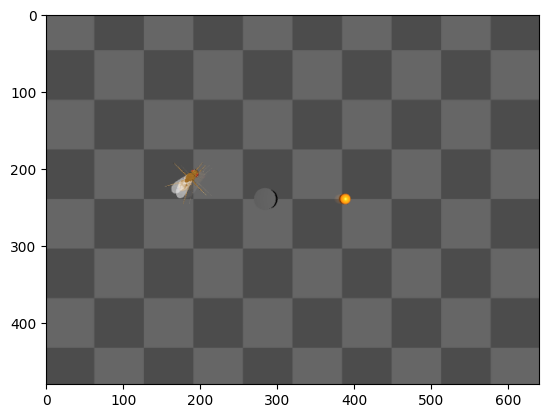

In [5]:
plt.imshow(sim.controller._frames[0])

Logging to logs/trial_8
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
resetting environment


  1%|          | 1/100 [00:03<05:23,  3.27s/it]

fly_pos: [0.10338673 0.01977945], final reward=-1.2629470983745361, state=seeking
  dist rew=0.103374, danger=0.683, action diff=0.000, tgt rew=0.000
  dist=14.897


  2%|▏         | 2/100 [00:05<04:27,  2.73s/it]

fly_pos: [-0.10715183  0.1606728 ], final reward=-1.1847141749067545, state=seeking
  dist rew=-0.211380, danger=0.478, action diff=0.016, tgt rew=0.000
  dist=15.108


  3%|▎         | 3/100 [00:10<05:38,  3.49s/it]

fly_pos: [0.15870662 0.20590112], final reward=-1.1446924630008966, state=seeking
  dist rew=0.265285, danger=0.705, action diff=0.000, tgt rew=0.000
  dist=14.843


  4%|▍         | 4/100 [00:13<05:16,  3.29s/it]

fly_pos: [0.65758562 0.21720672], final reward=-0.6660533624784366, state=seeking
  dist rew=0.498663, danger=0.581, action diff=0.002, tgt rew=0.000
  dist=14.344


  5%|▌         | 5/100 [00:15<04:42,  2.97s/it]

fly_pos: [1.02031696 0.18801649], final reward=-0.8546345508825532, state=seeking
  dist rew=0.363112, danger=0.608, action diff=0.002, tgt rew=0.000
  dist=13.981


  6%|▌         | 6/100 [00:19<05:30,  3.52s/it]

fly_pos: [1.65870303 0.24390446], final reward=-1.3302094616713673, state=seeking
  dist rew=0.637421, danger=0.984, action diff=0.001, tgt rew=0.000
  dist=13.344


  7%|▋         | 7/100 [00:22<05:10,  3.34s/it]

fly_pos: [2.21756945 0.18272633], final reward=-0.7241579862229823, state=seeking
  dist rew=0.559790, danger=0.642, action diff=0.001, tgt rew=0.000
  dist=12.784


  8%|▊         | 8/100 [00:26<05:01,  3.28s/it]

fly_pos: [2.90942981 0.30785138], final reward=-0.9804364604923586, state=seeking
  dist rew=0.689248, danger=0.835, action diff=0.000, tgt rew=0.000
  dist=12.094


  9%|▉         | 9/100 [00:28<04:36,  3.04s/it]

fly_pos: [3.35397519 0.23960373], final reward=-1.5409191813575938, state=seeking
  dist rew=0.445999, danger=0.993, action diff=0.000, tgt rew=0.000
  dist=11.648


 10%|█         | 10/100 [00:31<04:26,  2.96s/it]

fly_pos: [3.95360284 0.36080121], final reward=-0.6866859290617369, state=seeking
  dist rew=0.596201, danger=0.641, action diff=0.000, tgt rew=0.000
  dist=11.052


 11%|█         | 11/100 [00:33<04:03,  2.74s/it]

fly_pos: [4.73517805 0.41075331], final reward=-0.9566375056640233, state=seeking
  dist rew=0.779251, danger=0.868, action diff=0.000, tgt rew=0.000
  dist=10.273


 11%|█         | 11/100 [00:36<04:56,  3.33s/it]

fly_pos: [5.17129531 0.43538246], final reward=-2.668306908130384, state=collision
  dist rew=0.434694, danger=0.834, action diff=0.000, tgt rew=0.000
  dist=9.838
terminated
terminated


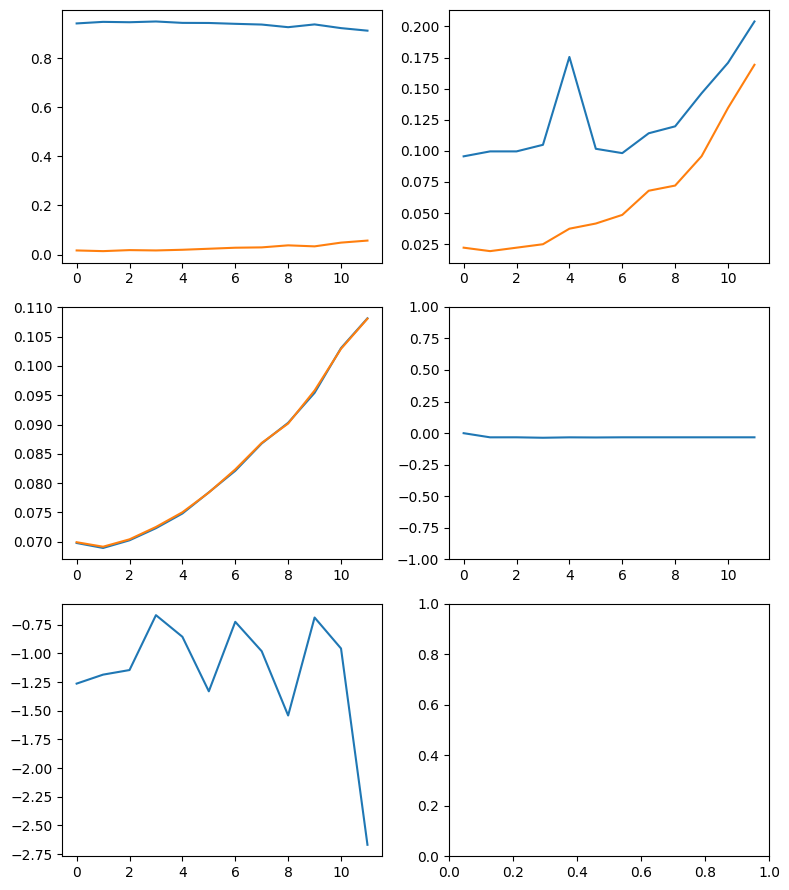

In [7]:
sim = NMFNavigation(
    arena_factory=make_arena,
    test_mode=True,
    debug_mode=True,
)

np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)
start_from = "logs/trial_23/trial_23_90000_steps.zip"
train = False

log_dir = "logs/trial_8"
checkpoint_callback = callbacks.CheckpointCallback(
    save_freq=100,
    save_path=log_dir,
    name_prefix="trial_8",
    save_replay_buffer=True,
    save_vecnormalize=True,
    verbose=2,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC(
    "MlpPolicy",
    # env=sim,
    env=sim,
    policy_kwargs={"net_arch": [16, 16]},
    verbose=2,
    learning_rate=0.01,
)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=50_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/trial_8")

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset(spawn_pos=[0, 0, 0.2])
for i in trange(100):
    action, _ = model.predict(obs, deterministic=True)    
    obs, reward, terminated, truncated, info = sim.step(action)
    action_hist.append(action)
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.controller.save_video(Path(start_from).stem + ".mp4")

fig, axs = plt.subplots(3, 2, figsize=(8, 9), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 1].plot(obs_hist[:, 2])
axs[0, 1].plot(obs_hist[:, 3])
axs[1, 0].plot(obs_hist[:, 4])
axs[1, 0].plot(obs_hist[:, 5])
axs[1, 1].plot(action_hist)
axs[1, 1].set_ylim(-1, 1)
axs[2, 0].plot(reward_hist)

In [ ]:
# sample_interval = 30
# individual_frames_dir = Path("outputs/individual_frames")
# individual_frames_dir.mkdir(parents=True, exist_ok=True)

# offset = max(0, len(sim._frames) % sample_interval - 1)
# # print(len(sim._frames), offset)
# selected_images = np.array(
#     [sim._frames[i] for i in range(offset, len(sim._frames), sample_interval)]
# )
# background = np.median(np.array(sim._frames), axis=0)

# for i in trange(0, selected_images.shape[0]):
#     img = selected_images[i, :, :, :]
#     is_background = np.isclose(img, background, atol=1).all(axis=2)
#     img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
#     img_alpha[:, :, :3] = img
#     img_alpha[is_background, 3] = 0
#     img_alpha = img_alpha.astype(np.uint8)
#     # break
#     imageio.imwrite(
#         individual_frames_dir / f"frame_{i}.png", img_alpha
#     )

# imageio.imwrite(individual_frames_dir / "background.png", background.astype(np.uint8))

In [ ]:
len(sim._frames)

In [ ]:
list(range(offset, len(sim._frames), sample_interval))